In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# installing libraries

!cp -rp /kaggle/input/pyspellchecker-and-ekpharasis-libs-for-python /kaggle/working/
!cp -rp /kaggle/input/transformers280 /kaggle/working/

!pip install /kaggle/working/pyspellchecker-and-ekpharasis-libs-for-python/pyspellchecker-0.5.4-py2.py3-none-any.whl >> /dev/null

!pip install /kaggle/working/pyspellchecker-and-ekpharasis-libs-for-python/ekphrasis-0.5.1/ekphrasis-0.5.1/ >> /dev/null
!python /kaggle/working/pyspellchecker-and-ekpharasis-libs-for-python/ekphrasis-0.5.1/ekphrasis-0.5.1/setup.py install >> /dev/null
!mkdir -p /root/.ekphrasis/stats 
!cp -r /kaggle/working/pyspellchecker-and-ekpharasis-libs-for-python/stats/* /root/.ekphrasis/stats >> /dev/null

!pip install /kaggle/working/transformers280/transformers-2.8.0 >> /dev/null

!rm -rf /kaggle/working/*

/opt/conda/lib/python3.7/site-packages/setuptools/command/easy_install.py:343: UserWarning: Unbuilt egg for ekphrasis [unknown version] (/kaggle/working/pyspellchecker-and-ekpharasis-libs-for-python/ekphrasis-0.5.1/ekphrasis-0.5.1)
  self.local_index = Environment(self.shadow_path + sys.path)

zip_safe flag not set; analyzing archive contents...
ERROR: Could not find a version that satisfies the requirement tokenizers==0.5.2 (from transformers==2.8.0) (from versions: none)
ERROR: No matching distribution found for tokenizers==0.5.2 (from transformers==2.8.0)


# Start

### Define Mode

In [3]:
in_testing_mode = True

### import some useful libs

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import copy
import os
import re # regular expression

from nltk.tokenize import SpaceTokenizer

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from spellchecker import SpellChecker

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import RobertaConfig, RobertaModel, BertPreTrainedModel, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup

import datetime, time

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [5]:
input_dir = '/kaggle/input'
working_dir = '/kaggle/working'
data_dir = os.path.join(input_dir, "tweet-sentiment-extraction/")
model_dir = os.path.join(input_dir, "robertabase/")

train_file = os.path.join(data_dir, "train.csv")
test_file = os.path.join(data_dir, "test.csv")

sample_submission_file = os.path.join(data_dir, "sample_submission.csv")
submission_file = os.path.join(working_dir, "submission.csv")

### Load dataframes

In [6]:
dfTrain = pd.read_csv(train_file,encoding="utf-8")
dfTest = pd.read_csv(test_file,encoding="utf-8")
print("dfTrain")
print(dfTrain.describe())
print("\n====================================\n")
print("dfTest")
print(dfTest.describe())

dfTrain
            textID                                               text  \
count        27481                                              27480   
unique       27481                                              27480   
top     a1d7825499   I can understand the fear. I feel that way ab...   
freq             1                                                  1   

       selected_text sentiment  
count          27480     27481  
unique         22463         3  
top             good   neutral  
freq             199     11118  


dfTest
            textID                                               text  \
count         3534                                               3534   
unique        3534                                               3534   
top     e8bbfed756  _MileyCyrus it wont let me do it twitter keeps...   
freq             1                                                  1   

       sentiment  
count       3534  
unique         3  
top      neutral  
freq      

In [7]:
print("dfTrain")
print(dfTrain.info())
print("\n====================================\n")
print("dfTest")
print(dfTest.info())

dfTrain
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None


dfTest
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB
None


In [8]:
dfTrain.dropna(inplace=True,axis=0)
dfTrain = dfTrain[~dfTrain.text.str.contains("ï|¿|½")] # drop columns that include some unknown chars("ï|¿|½")
dfTrain.reset_index(inplace=True,drop=True)

print("dfTrain describe")
print(dfTrain.describe())
print("\n====================================\n")
print("dfTrain info")
print(dfTrain.info())

dfTrain describe
            textID                                               text  \
count        27325                                              27325   
unique       27325                                              27325   
top     a1d7825499   I can understand the fear. I feel that way ab...   
freq             1                                                  1   

       selected_text sentiment  
count          27325     27325  
unique         22332         3  
top             good   neutral  
freq             197     11039  


dfTrain info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27325 entries, 0 to 27324
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27325 non-null  object
 1   text           27325 non-null  object
 2   selected_text  27325 non-null  object
 3   sentiment      27325 non-null  object
dtypes: object(4)
memory usage: 854.0+ KB
None


In [9]:
dfTrain.head(20)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive
7,50e14c0bb8,Soooo high,Soooo high,neutral
8,e050245fbd,Both of you,Both of you,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive


### visualize the sentiments

As we can see below there is 3 sentiment type. Positive and negative sentiments distributed in close proportions.

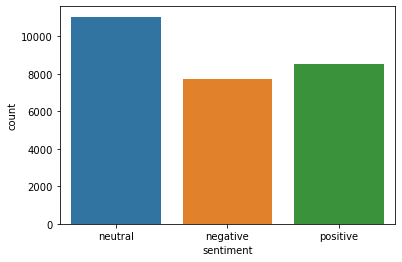

In [10]:
sns.countplot(x= 'sentiment',data = dfTrain)

Now let's find out how much the selected text keeps part of the text in different sentiments.

In [11]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [12]:
dfJaccards = copy.deepcopy(dfTrain)
dfJaccards["jaccard"] = dfJaccards.apply(lambda df: jaccard(df.text, df.selected_text), axis=1)
print("Ratios of selected text in text")
dfJaccards = dfJaccards[['sentiment','jaccard']].groupby(['sentiment']).mean()
dfJaccards

Ratios of selected text in text


,jaccard
sentiment,
negative,0.339007
neutral,0.977046
positive,0.314537


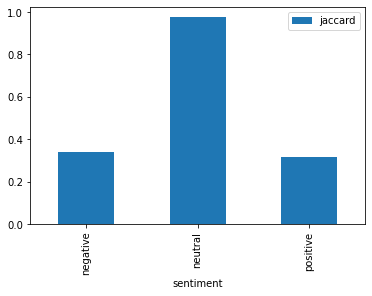

In [13]:
dfJaccards.plot.bar()
del(dfJaccards)

As we can see above the **selected text contains almost all text in Neutral Sentiment**

# Data Cleaning

### Split texts

One of the most important points is here. We will divide the tweet text and selected text into words and put them into a list. Then we will assign a number to every word in the tweet text for accesing to orginal form after cleaning. However, since we will work word-based rather than character-based, we will extract the selected text list as it is in the tweet text list. In this way, even if the selected text is cropped in letters, it will appear in list as cropped in words.

In [14]:
def stringtowords(text, selected_text):
    text_words = str(text).lower().split()
    selected_text_words = str(selected_text).lower().split()
    selected_length = len(selected_text_words)
    start_char = "".join(text_words).find("".join(selected_text_words))
    if(start_char >= 0 and selected_length > 0):
        remaining_char = start_char
        for i,word in enumerate(text_words):
            remaining_char-=len(word)
            if remaining_char < 0:
                selected_text_words = text_words[i:i+selected_length]
                break
            
    text_word_numbers = [i for i in range(len(text_words))]
    return text_words, text_word_numbers ,selected_text_words

In [15]:
test_string = "is back home now gonna miss every one" #dfTrain[dfTrain["textID"] == "af3fed7fc3"]
test_selected_string = "onna mis"
print("Sample text:\t", test_string)
print("Sample selected text:\t", test_selected_string)

output_tweet_list, output_tweet_word_numbers, output_selected_list = stringtowords(test_string,test_selected_string)
print("\nstringtowords outputs")
print("output tweet list: ",output_tweet_list)
print("output tweet word numbers:",output_tweet_word_numbers)
print("output selected text list: ",output_selected_list)

Sample text:	 is back home now gonna miss every one
Sample selected text:	 onna mis

stringtowords outputs
output tweet list:  ['is', 'back', 'home', 'now', 'gonna', 'miss', 'every', 'one']
output tweet word numbers: [0, 1, 2, 3, 4, 5, 6, 7]
output selected text list:  ['gonna', 'miss']


In [16]:
dfTrain['text_w'], dfTrain['text_w_n'], dfTrain['selected_w'] = zip(*dfTrain.apply(lambda df: stringtowords(df.text,df.selected_text), axis=1))
dfTrain.head()

,textID,text,selected_text,sentiment,text_w,text_w_n,selected_w
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"[i`d, have, responded,, if, i, were, going]","[0, 1, 2, 3, 4, 5, 6]","[i`d, have, responded,, if, i, were, going]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,"[sooo, sad, i, will, miss, you, here, in, san,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]","[sooo, sad]"
2,088c60f138,my boss is bullying me...,bullying me,negative,"[my, boss, is, bullying, me...]","[0, 1, 2, 3, 4]","[bullying, me...]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,"[what, interview!, leave, me, alone]","[0, 1, 2, 3, 4]","[leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"[sons, of, ****,, why, couldn`t, they, put, th...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[sons, of, ****,]"


In [17]:
print("text")
print(dfTrain["text_w"].iloc[0])
print("selected_text")
print(dfTrain["selected_w"].iloc[0])

text
['i`d', 'have', 'responded,', 'if', 'i', 'were', 'going']
selected_text
['i`d', 'have', 'responded,', 'if', 'i', 'were', 'going']


### Defining difference fixer function

With the help of the following function, the numbers of the words are arranged according to the old word and the processed word, so as an example

**Before Processing**

| text_w         | text_w_n |
|----------------|----------|
|["dont","split"]|  [0,1]   |

**After Processing**

| text_w             | text_w_n |
|--------------------|----------|
|["do","not","split"]| [0,0,1]  |

In [18]:
def fix_difference(old_word, new_word, oldtext_w_n, newtext_w, newtext_w_n, word_ind, expand_number):
    new_word = [word for word in new_word if word != ""] # simple empty word delete function
    if len(new_word) == 0:
        newtext_w.pop(word_ind+expand_number)
        if newtext_w_n is not None:
            newtext_w_n.pop(word_ind+expand_number)
        expand_number -= 1
    elif (len(new_word) > 1) | (new_word[0] != old_word):
        for i, word in enumerate(new_word):
            if i == 0:
                newtext_w[word_ind+expand_number] = word
            else:
                expand_number += 1
                newtext_w.insert(word_ind+expand_number,word)
                if newtext_w_n is not None:
                    newtext_w_n.insert(word_ind+expand_number,oldtext_w_n[word_ind])
    return newtext_w, newtext_w_n, expand_number

### Clean the missing quotes or some undefined word

In [19]:
def cleanstring(oldtext_w, oldtext_w_n = None):
    dictionary = {'w/':'with',
                  'dont':'do not',
                  'doesnt':'does not',
                  'didnt':'did not',
                  'cant':'can not',
                  'couldnt':'could not',
                  'wouldnt':'would not',
                  'shouldnt':'should not'
                 }
    expand = 0
    newtext_w = copy.deepcopy(oldtext_w)
    newtext_w_n = copy.deepcopy(oldtext_w_n)
    for word_ind ,current_word in enumerate(oldtext_w):
        new_word = current_word
        if current_word in dictionary:
            new_word = dictionary[current_word]
        
        new_word = new_word.split()
        newtext_w, newtext_w_n, expand = fix_difference(current_word, new_word, oldtext_w_n, newtext_w, newtext_w_n, word_ind, expand)
    return newtext_w, newtext_w_n

In [20]:
test_string = ["u","cant","seperate","it","w/","this"]
print("Before cleanstring")
print(test_string)
print("After cleanstring")
print(cleanstring(test_string)[0])

Before cleanstring
['u', 'cant', 'seperate', 'it', 'w/', 'this']
After cleanstring
['u', 'can', 'not', 'seperate', 'it', 'with', 'this']


In [21]:
dfTrain['text_w'], dfTrain['text_w_n'] = zip(*dfTrain.apply(lambda df: cleanstring(df.text_w,df.text_w_n), axis=1))
dfTrain['selected_w'], _ = zip(*dfTrain.apply(lambda df: cleanstring(df.selected_w), axis=1))
print("===== E> Replaced unpunctuated texts with punctuated ones <3 =====")

===== E> Replaced unpunctuated texts with punctuated ones <3 =====


### Use ekphrasis to convert text like urls to tags

In [22]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url'],
    # terms that will be annotated
    annotate={},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=False, #True, # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    
    # select a tokenizer. We selected SpaceTokenizer, you can understand it in 
    # add spaces before word section
    tokenizer=SpaceTokenizer().tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    dicts=[emoticons]
)

def tweetCleaner(oldtext_w, oldtext_w_n = None):
    expand = 0
    newtext_w = copy.deepcopy(oldtext_w)
    newtext_w_n = copy.deepcopy(oldtext_w_n)
    for word_ind ,current_word in enumerate(oldtext_w):
        new_word = current_word
        new_word = text_processor.pre_process_doc(current_word)
        for i,word in enumerate(new_word):
            if "<" in word and ">" in word:  # unpack the tags that tweetcleaner created
                new_word[i] = re.sub("[<>]","",word)
        newtext_w, newtext_w_n, expand = fix_difference(current_word, new_word, oldtext_w_n, newtext_w, newtext_w_n, word_ind, expand)
    return newtext_w, newtext_w_n

Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt


In [23]:
test_string = ["@rootofarch","https://kaggle.com","is","working!!!!",":D","#tbt"]
print("Before tweetCleaner")
print(test_string)
print("After tweetCleaner")
print(tweetCleaner(test_string)[0])

Before tweetCleaner
['@rootofarch', 'https://kaggle.com', 'is', 'working!!!!', ':D', '#tbt']
After tweetCleaner
['@rootofarch', 'url', 'is', 'working!!!!', 'laugh', '#tbt']


In [24]:
dfTrain['text_w'], dfTrain['text_w_n'] = zip(*dfTrain.apply(lambda df: tweetCleaner(df.text_w,df.text_w_n), axis=1))
dfTrain['selected_w'], _ = zip(*dfTrain.apply(lambda df: tweetCleaner(df.selected_w), axis=1))
print("===== E> Applied ekphrasis text preprocessor <3 =====")

===== E> Applied ekphrasis text preprocessor <3 =====


### Convert some repeated text to a tag

In [25]:
def cleanstring2(oldtext_w, oldtext_w_n = None):
    dictionary = {'ahah':'laugh',
                  'haha':'laugh',
                  'ahhah':'laugh',
                  'haaha':'laugh',
                  'hahha':'laugh',
                  'ahaah':'laugh',
                  'oxox':'kiss',
                  'xoxo':'kiss',
                  'xxox':'kiss',
                  'ooxo':'kiss'
                 }
    expand = 0
    newtext_w = copy.deepcopy(oldtext_w)
    newtext_w_n = copy.deepcopy(oldtext_w_n)
    for word_ind ,current_word in enumerate(oldtext_w):
        new_word = current_word
        for repeated in dictionary.keys():
            if repeated in current_word:
                new_word = dictionary[repeated]

        new_word = new_word.split()
        newtext_w, newtext_w_n, expand = fix_difference(current_word, new_word, oldtext_w_n, newtext_w, newtext_w_n, word_ind, expand)
    return newtext_w, newtext_w_n

In [26]:
test_string = ["ahhahahahaha","it","is","a","dummy","string","xoxoxooxoxoxo"]
print("Before cleanstring2")
print(test_string)
print("After cleanstring2")
print(cleanstring2(test_string)[0])

Before cleanstring2
['ahhahahahaha', 'it', 'is', 'a', 'dummy', 'string', 'xoxoxooxoxoxo']
After cleanstring2
['laugh', 'it', 'is', 'a', 'dummy', 'string', 'kiss']


In [27]:
dfTrain['text_w'], dfTrain['text_w_n'] = zip(*dfTrain.apply(lambda df: cleanstring2(df.text_w,df.text_w_n), axis=1))
dfTrain['selected_w'], _ = zip(*dfTrain.apply(lambda df: cleanstring2(df.selected_w), axis=1))
print("===== E> Some repeated structures replaced with their meanings <3 =====")

===== E> Some repeated structures replaced with their meanings <3 =====


### Correct misspellings

In [28]:
spell = SpellChecker(distance=1) # Set max how many chars can be misstyped in a word

def correctSpelling(oldtext_w, oldtext_w_n = None):
    expand = 0
    newtext_w = copy.deepcopy(oldtext_w)
    newtext_w_n = copy.deepcopy(oldtext_w_n)
    for word_ind ,current_word in enumerate(oldtext_w):
        new_word = spell.correction(current_word)
        new_word = new_word.split()
        newtext_w, newtext_w_n, expand = fix_difference(current_word, new_word, oldtext_w_n, newtext_w, newtext_w_n, word_ind, expand)
    return newtext_w, newtext_w_n

In [29]:
test_string = ["it","is","not","an","englidh","wotd"]
print("Before correctSpelling")
print(test_string)
print("After correctSpelling")
print(correctSpelling(test_string)[0])

Before correctSpelling
['it', 'is', 'not', 'an', 'englidh', 'wotd']
After correctSpelling
['it', 'is', 'not', 'an', 'english', 'word']


In [30]:
dfTrain['text_w'], dfTrain['text_w_n'] = zip(*dfTrain.apply(lambda df: correctSpelling(df.text_w,df.text_w_n), axis=1))
dfTrain['selected_w'], _ = zip(*dfTrain.apply(lambda df: correctSpelling(df.selected_w), axis=1))
print("===== E> Fixed 1 char typos <3 =====")

===== E> Fixed 1 char typos <3 =====


## Add spaces before words

Roberta's tokenizer tokenizes the words " world" and "world" differently. Since we separated the words for cleaning, we lost the spaces between them. In other words, the input that we should normally give as "Hello world" is now as "Helloworld". Therefore, we should make our input as " Hello world" to make the tokenizer do its job more accurately.

In [31]:
def addSpace(oldtext_w):
    newtext_w = copy.deepcopy(oldtext_w)
    for word_ind ,current_word in enumerate(oldtext_w):
            newtext_w[word_ind] = " "+current_word
    return newtext_w

In [32]:
test_string = ["hello","world"]
print("Before addSpace")
print(test_string)
print("After addSpace")
print(addSpace(test_string))

Before addSpace
['hello', 'world']
After addSpace
[' hello', ' world']


In [33]:
dfTrain['text_w'] = dfTrain.apply(lambda df: addSpace(df.text_w), axis=1)
dfTrain['selected_w'] = dfTrain.apply(lambda df: addSpace(df.selected_w), axis=1)
print("===== E> Added spaces before every word <3 =====")

===== E> Added spaces before every word <3 =====


## Apply all the cleanings to test dataframe

In [34]:
dfTest['text_w'], dfTest['text_w_n'], _ = zip(*dfTest.apply(lambda df: stringtowords(df.text,"")             , axis=1))
dfTest['text_w'], dfTest['text_w_n']    = zip(*dfTest.apply(lambda df: cleanstring(df.text_w,df.text_w_n)    , axis=1))
dfTest['text_w'], dfTest['text_w_n']    = zip(*dfTest.apply(lambda df: tweetCleaner(df.text_w,df.text_w_n)   , axis=1))
dfTest['text_w'], dfTest['text_w_n']    = zip(*dfTest.apply(lambda df: cleanstring2(df.text_w,df.text_w_n)   , axis=1))
dfTest['text_w'], dfTest['text_w_n']    = zip(*dfTest.apply(lambda df: correctSpelling(df.text_w,df.text_w_n), axis=1))
dfTest['text_w']                        = dfTest.apply(lambda df: addSpace(df.text_w), axis=1)
dfTest.sample(n=5, random_state=50)

,textID,text,sentiment,text_w,text_w_n
3173,23d8ccab77,did not sleep a wink last night X,neutral,"[ did, not, sleep, a, wink, last, night,...","[0, 1, 2, 3, 4, 5, 6, 7]"
1759,ec8507eef4,haha. Thanks Shannon. 3 out of 5 boats got f...,positive,"[ laugh, thanks, shannon, 3, out, of, 5,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]"
1848,c9dfbf4275,I have a new found respect for you now that I...,neutral,"[ i, have, a, new, found, respect, for, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3420,9ef3a57e41,I know! I miss her...,negative,"[ i, know, i, miss, her...]","[0, 1, 2, 3, 4]"
36,c7f9d559e2,Happy mothers day mumm xoxo,positive,"[ happy, mothers, day, mumm, kiss]","[0, 1, 2, 3, 4]"


# Roberta Tokenizer

In [35]:
print('Loading RoBERTa tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained(model_dir)

Loading RoBERTa tokenizer...


In [36]:
def robertaTokenize(oldtext_w, oldtext_w_n = None):
    expand = 0
    newtext_w = copy.deepcopy(oldtext_w)
    newtext_w_n = copy.deepcopy(oldtext_w_n)
    for word_ind ,current_word in enumerate(oldtext_w):
        new_word = tokenizer.tokenize(current_word)
        newtext_w, newtext_w_n, expand = fix_difference(current_word, new_word, oldtext_w_n, newtext_w, newtext_w_n, word_ind, expand)
    return newtext_w, newtext_w_n

In [37]:
test_string = [" hello"," worldasd"]
print("Before robertaTokenize")
print(test_string)
print("After robertaTokenize")
print(robertaTokenize(test_string)[0])

Before robertaTokenize
[' hello', ' worldasd']
After robertaTokenize
['Ġhello', 'Ġworld', 'as', 'd']


In [38]:
dfTrain['text_w'], dfTrain['text_w_n'] = zip(*dfTrain.apply(lambda df: robertaTokenize(df.text_w,df.text_w_n), axis=1))
dfTrain['selected_w'], _ = zip(*dfTrain.apply(lambda df: robertaTokenize(df.selected_w), axis=1))
print("===== E> Tokenized every word using RoBERTa tokenization <3 =====")

===== E> Tokenized every word using RoBERTa tokenization <3 =====


We should also apply this tokenization to the test dataframe

In [39]:
dfTest['text_w'], dfTest['text_w_n'] = zip(*dfTest.apply(lambda df: robertaTokenize(df.text_w,df.text_w_n), axis=1))
dfTest.sample(n=5, random_state=50)

,textID,text,sentiment,text_w,text_w_n
3173,23d8ccab77,did not sleep a wink last night X,neutral,"[Ġdid, Ġnot, Ġsleep, Ġa, Ġwink, Ġlast, Ġnight,...","[0, 1, 2, 3, 4, 5, 6, 7]"
1759,ec8507eef4,haha. Thanks Shannon. 3 out of 5 boats got f...,positive,"[Ġlaugh, Ġthanks, Ġsh, annon, Ġ3, Ġout, Ġof, Ġ...","[0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9]"
1848,c9dfbf4275,I have a new found respect for you now that I...,neutral,"[Ġi, Ġhave, Ġa, Ġnew, Ġfound, Ġrespect, Ġfor, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3420,9ef3a57e41,I know! I miss her...,negative,"[Ġi, Ġknow, Ġi, Ġmiss, Ġher, ...]","[0, 1, 2, 3, 4, 4]"
36,c7f9d559e2,Happy mothers day mumm xoxo,positive,"[Ġhappy, Ġmothers, Ġday, Ġm, umm, Ġkiss]","[0, 1, 2, 3, 3, 4]"


# Prepare Train Output

After this point, we need to prepare the output we will expect from the model. Since we apply all operations to both tweet text and selected text, we can find the position of the selected text in the tweet text. The following function is defined for this job. This function returns the start and end word order of the selected text in the tweet text even if there are some errors and missings.

In [40]:
def find_sub_list(sub_list,super_list):
    sub_list_length=len(sub_list)
    matching_list = []
    found_start = 0
    for start in range(0,sub_list_length): # find first matching word
        for ind in (j for j,e in enumerate(super_list) if e==sub_list[start]): # for every matched first word
            found_start = ind-start
            if sub_list_length < 2:
                return [ind-start,ind-start+sub_list_length-1]
            else:
                for end in range(sub_list_length,start+1,-1): # from last to first every word as last word
                    if super_list[ind:ind+end-start]==sub_list[start:end]: # if first to last matches
                        return [ind-start,ind-start+sub_list_length-1] # return first(possible) and last(possible)+1 index
    return [found_start, found_start+sub_list_length-1] # if you couldn't find the part you just return by any first match of super list

In [41]:
test_string = ["this","is","a","super","list"]
test_selected_string = ["r","list"]
print("super list")
print(test_string)
print("sub list")
print(test_selected_string)
print("location that find_sub_list found")
print(find_sub_list(test_selected_string,test_string))

super list
['this', 'is', 'a', 'super', 'list']
sub list
['r', 'list']
location that find_sub_list found
[3, 4]


In [42]:
dfTrain['selected_start_end'] = dfTrain.apply(lambda df: find_sub_list(df.selected_w,df.text_w), axis=1)
dfTrain.head()

,textID,text,selected_text,sentiment,text_w,text_w_n,selected_w,selected_start_end
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"[Ġid, Ġhave, Ġresponded, Ġif, Ġi, Ġwere, Ġgoing]","[0, 1, 2, 3, 4, 5, 6]","[Ġid, Ġhave, Ġresponded, Ġif, Ġi, Ġwere, Ġgoing]","[0, 6]"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,"[Ġsoon, Ġsad, Ġi, Ġwill, Ġmiss, Ġyou, Ġhere, Ġ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9]","[Ġsoon, Ġsad]","[0, 1]"
2,088c60f138,my boss is bullying me...,bullying me,negative,"[Ġmy, Ġboss, Ġis, Ġbullying, Ġme, ...]","[0, 1, 2, 3, 4, 4]","[Ġbullying, Ġme, ...]","[3, 5]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,"[Ġwhat, Ġinterview, Ġleave, Ġme, Ġalone]","[0, 1, 2, 3, 4]","[Ġleave, Ġme, Ġalone]","[2, 4]"
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,"[Ġsons, Ġof, Ġ****, ,, Ġwhy, Ġcould, nt, Ġthey...","[0, 1, 2, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 1...","[Ġsons, Ġof, Ġ****, ,]","[0, 3]"


# Split Train data to Train and Last Test

if in_testing_mode allocate some of the data for testing purpose

In [43]:
if in_testing_mode:
    dfTrain, dfLasttest = train_test_split(dfTrain, test_size=0.01, random_state=50)
    dfTrain.reset_index(drop=True, inplace=True)
    dfLasttest.reset_index(drop=True, inplace=True)

# Hugging Face

Detect the device that notebook runs on

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("the device we will run on is: ",device)
if device.type == "cuda":
    print("the GPU is: ", torch.cuda.get_device_name(0))

the device we will run on is:  cuda:0
the GPU is:  Tesla P100-PCIE-16GB


In [45]:
test_question = "positive"
test_string = [" hello"," world"]
test_context  = robertaTokenize(test_string)[0]
print("question: ", test_question)
print("context: ", test_context)
test = tokenizer.encode_plus(
                      [test_question],                # sentiment to encode
                      test_context,                   # Sentence to encode.
                      add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                      max_length = 10,            # Pad & truncate all sentences.
                      pad_to_max_length = True,
                      return_token_type_ids = True,
                      return_attention_mask = True,   # Construct attn. masks.
                      device=device,
                      return_tensors = 'pt',      # Return pytorch tensors.
                      )
print("input_ids: ",test["input_ids"])
print("attention_mask: ",test["attention_mask"])
print("token_type_ids: ",test["token_type_ids"])
print("decoded: ",tokenizer.decode(test["input_ids"][0]))

question:  positive
context:  ['Ġhello', 'Ġworld']
input_ids:  tensor([[    0, 22173,     2,     2, 20760,   232,     2,     1,     1,     1]])
attention_mask:  tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])
token_type_ids:  tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
decoded:  <s>positive</s></s> hello world</s><pad><pad><pad>


As we can see above we are using 5 additional tokens in roberta tokenizer. These are:

*   1 * **0**
*   1 * **sentiment's id**
*   3 * **2** 

So we need to calculate the longest contexts length of tweet text and add 5 to it. Thus, we will have the max input size.

In [46]:
max_word_count = max(np.max(dfTrain["text_w"].apply(lambda x: len(x))), np.max(dfTest["text_w"].apply(lambda x: len(x))))
max_word_count+=5
print("Max clean word count is {}".format(max_word_count))

Max clean word count is 71


We will define a function that creates and collects the encoded values in lists

In [47]:
def convert_text2ids(sentiment, word_list, output, max_word_count, input_ids, attention_masks, token_type_ids, start_positions, end_positions):
    encoded_dict = tokenizer.encode_plus(
                                          [sentiment],                  # sentiment to encode
                                          word_list,                    # Sentence to encode.
                                          add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                                          max_length = max_word_count,  # Pad & truncate all sentences.
                                          pad_to_max_length = True,     # Create with padding.
                                          return_token_type_ids = True, # Construct token type ids.
                                          return_attention_mask = True, # Construct attn. masks.
                                          device=device,
                                          return_tensors = 'pt',        # Return pytorch tensors.
                                        )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])
    token_type_ids.append(encoded_dict['token_type_ids'])
    if output is not None:
        start_positions.append(output[0])
        end_positions.append(output[1])

In [48]:
train_input_ids, train_attention_masks, train_token_type_ids, train_start_positions, train_end_positions  = [], [], [], [], []

dfTrain.apply(lambda df: convert_text2ids(df.sentiment, df.text_w, df.selected_start_end, max_word_count, train_input_ids, train_attention_masks, train_token_type_ids, train_start_positions, train_end_positions), axis=1)

# convert lists to torch tensors
train_input_ids = torch.cat(train_input_ids, dim=0) 
train_attention_masks = torch.cat(train_attention_masks, dim=0)
train_token_type_ids = torch.cat(train_token_type_ids, dim=0)
train_start_positions = torch.tensor(train_start_positions, dtype = torch.long)
train_end_positions = torch.tensor(train_end_positions, dtype = torch.long)

In [49]:
print("Shape of train input ids: ", train_input_ids.size())
print("Shape of train input masks: ", train_attention_masks.size())
print("Shape of train token type ids: ", train_token_type_ids.size())
print("Shape of train output start positions: ", train_start_positions.size())
print("Shape of train output end positions: ", train_end_positions.size())

Shape of train input ids:  torch.Size([27051, 71])
Shape of train input masks:  torch.Size([27051, 71])
Shape of train token type ids:  torch.Size([27051, 71])
Shape of train output start positions:  torch.Size([27051])
Shape of train output end positions:  torch.Size([27051])


## RoBerta MODEL

In [50]:
batch_size = 64

# Number of training epochs.
epochs = 4

learning_rate = 5e-5
adam_epsilon = 1e-8

validation_size = 0.01

# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#### Preparing tensor dataset


In [51]:
data = TensorDataset(train_input_ids,
                     train_attention_masks,
                     train_token_type_ids,
                     train_start_positions,
                     train_end_positions)

train_data_size = int((1-validation_size) * len(data))
val_data_size = len(data) - train_data_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_data_size, val_data_size])

train_dataloader = DataLoader(train_dataset, # The train samples.
                              sampler=RandomSampler(train_dataset), # Pull out batches randomly.
                              batch_size = batch_size)# Evaluate with this batch size.

val_dataloader   = DataLoader(val_dataset, # The validation samples.
                              sampler=SequentialSampler(val_dataset), # Pull out batches sequentially.
                              batch_size = batch_size)# Evaluate with this batch size.

print("train data length :", len(train_dataset))
print("validation data length :", len(val_dataset))

train data length : 26780
validation data length : 271


In [52]:
random_step = random.randint(0,len(train_dataloader))
for step, batch in enumerate(train_dataloader):
    if step == random_step:
        random_data = random.randint(0,len(batch[0]))
        sample_input_id       = batch[0][random_data]
        sample_attention_mask = batch[1][random_data]
        sample_token_type_id  = batch[2][random_data]
        sample_start_position = batch[3][random_data]
        sample_end_position   = batch[4][random_data]
        break

print("sample_input_id")
print("\t",sample_input_id)
print("sample_attention_mask")
print("\t",sample_attention_mask)
print("sample_token_type_id")
print("\t",sample_token_type_id)
print("sample_start_position")
print("\t",sample_start_position)
print("sample_end_position")
print("\t",sample_end_position)

sample_input_id
	 tensor([    0, 33407,     2,     2, 45365,     5,   936,     5,  5567, 15797,
          939,   120,   259, 33976,    94,    55,    87,   132,   377,   117,
          948,    99,  1518,    50,   425,     2,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1])
sample_attention_mask
	 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
sample_token_type_id
	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Preparing model

In [53]:
class tweetModel(BertPreTrainedModel):
    def __init__(self, conf):
        super(tweetModel, self).__init__(conf)
        self.roberta = RobertaModel.from_pretrained(model_dir, config=conf)
        self.drop_out = nn.Dropout(0.1)
        self.l0 = nn.Linear(768 * 2, 2)
        torch.nn.init.normal_(self.l0.weight, std=0.02)
    
    def forward(self, dictionary):
        outputs = self.roberta(
            dictionary["input_ids"],
            attention_mask=dictionary["attention_mask"],
            token_type_ids=dictionary["token_type_ids"]
        )

        out = torch.cat((outputs[2][-1], outputs[2][-2]), dim=-1)
        out = self.drop_out(out)
        logits = self.l0(out)

        start_logits, end_logits = logits.split(1, dim=-1)

        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        outputs = (start_logits, end_logits)
        if "start_positions" in dictionary and "end_positions" in dictionary:  # if the output positions given also calculate and return the loss
            if dictionary["start_positions"] is not None and dictionary["end_positions"] is not None:
                if len(dictionary["start_positions"].size()) > 1:
                    dictionary["start_positions"] = dictionary["start_positions"].squeeze(-1)
                if len(dictionary["end_positions"].size()) > 1:
                    dictionary["end_positions"] = dictionary["end_positions"].squeeze(-1)
                # sometimes the start/end positions are outside our model inputs, we ignore these terms
                ignored_index = start_logits.size(1)
                dictionary["start_positions"].clamp_(0, ignored_index)
                dictionary["end_positions"].clamp_(0, ignored_index)

                loss_fct = nn.CrossEntropyLoss(ignore_index=ignored_index)
                start_loss = loss_fct(start_logits, dictionary["start_positions"])
                end_loss = loss_fct(end_logits, dictionary["end_positions"])
                total_loss = (start_loss + end_loss) / 2 # basicly average of start positon and end positon loss
                outputs = (total_loss,) + outputs

        return outputs  # (loss), start_logits, end_logits

In [54]:
rb_config = RobertaConfig.from_pretrained(model_dir , output_hidden_states = True)

# Initializing a model
model = tweetModel(conf=rb_config)
model.to(device)

tweetModel(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, el

#### Preparing optimizer

In [55]:
# prepare optimizer
param_optimizer = list(model.named_parameters())
# hack to remove "pooler"  which is not used
param_optimizer = [n for n in param_optimizer if 'pooler' not in n[0]]

no_decay =['bias','LayerNorm.weight']
optimizer_grouped_parameters =[
    {'params':[ p for n , p in param_optimizer 
               if not any(nd in n for nd in no_decay)],'weight_decay':0.01},
    {'params':[p for n, p in param_optimizer
               if any(nd in n for nd in no_decay)],'weigth_decay':0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = learning_rate,
                  eps = adam_epsilon
                 )

#### Preparing scheduler

In [56]:
# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_squad.py
                                            num_training_steps = total_steps)

# TRAINING

In [57]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Train function

In [58]:
# This training code is based on the `run_squad.py` script here:
# https://github.com/huggingface/transformers/blob/master/examples/question-answering/run_squad.py
def train(model, optimizer, scheduler, epochs, train_dataloader, validation_dataloader, training_stats): 
    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):
        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        print('\n======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long this training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
          # we'll copy each tensor to the GPU using the `to` method.
            batch_device = tuple(t.to(device) for t in batch)
            # Progress update every 20 batches.
            if step % 20 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            # a `batch` contains five pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: token type ids
            #   [3]: selected text start position in text
            #   [4]: selected text end position in text
            inputs = {
                      "input_ids": batch_device[0],
                      "attention_mask": batch_device[1],
                      "token_type_ids": batch_device[2],
                      "start_positions": batch_device[3],
                      "end_positions": batch_device[4],
                      }

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # It returns different numbers of parameters depending on what arguments
            # are given and what flags are set. For our useage here, it returns
            # the loss (because we provided start and end positions) and the "logits"
            # --the model outputs prior to activation.
            outputs = model(inputs)
            loss = outputs[0]

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("\n  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.
        print("\nRunning Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch and unpack the batches from the dataloader.
        for batch in validation_dataloader:
            batch_device = tuple(t.to(device) for t in batch)
            inputs = {
                      "input_ids": batch_device[0],
                      "attention_mask": batch_device[1],
                      "token_type_ids": batch_device[2],
                      "start_positions": batch_device[3],
                      "end_positions": batch_device[4],
                      }

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        
                outputs = model(inputs)
                loss = outputs[0]

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append({
                                'epoch': epoch_i + 1,
                                'Training Loss': avg_train_loss,
                                'Valid. Loss': avg_val_loss,
                                'Training Time': training_time,
                                'Validation Time': validation_time
                              })

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

### Train process

In [59]:
training_stats = []
train(model, optimizer, scheduler, epochs, train_dataloader, val_dataloader, training_stats)


======== Epoch 1 / 4 ========
Training...
  Batch    20  of    419.    Elapsed: 0:00:09.
  Batch    40  of    419.    Elapsed: 0:00:17.
  Batch    60  of    419.    Elapsed: 0:00:25.
  Batch    80  of    419.    Elapsed: 0:00:33.
  Batch   100  of    419.    Elapsed: 0:00:41.
  Batch   120  of    419.    Elapsed: 0:00:49.
  Batch   140  of    419.    Elapsed: 0:00:57.
  Batch   160  of    419.    Elapsed: 0:01:06.
  Batch   180  of    419.    Elapsed: 0:01:14.
  Batch   200  of    419.    Elapsed: 0:01:22.
  Batch   220  of    419.    Elapsed: 0:01:30.
  Batch   240  of    419.    Elapsed: 0:01:38.
  Batch   260  of    419.    Elapsed: 0:01:46.
  Batch   280  of    419.    Elapsed: 0:01:55.
  Batch   300  of    419.    Elapsed: 0:02:03.
  Batch   320  of    419.    Elapsed: 0:02:11.
  Batch   340  of    419.    Elapsed: 0:02:19.
  Batch   360  of    419.    Elapsed: 0:02:27.
  Batch   380  of    419.    Elapsed: 0:02:35.
  Batch   400  of    419.    Elapsed: 0:02:43.

  Average traini

### Train process visualization

In [60]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the index values.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.23,0.90,0:02:51,0:00:01
2,0.81,0.85,0:02:50,0:00:01
3,0.71,0.87,0:02:50,0:00:01
4,0.63,0.90,0:02:50,0:00:01


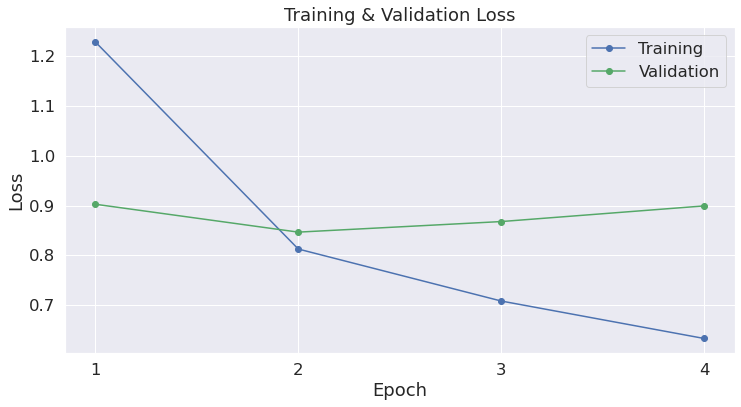

In [61]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(1,epochs+1)))

plt.show()

### Prediction sampling

In [62]:
random_step = random.randint(0,len(val_dataloader))
for step, batch in enumerate(val_dataloader):
    if step == random_step:
        random_data = random.randint(0,len(batch[0]))
        sample_input_id       = batch[0][random_data].to(device)
        sample_attention_mask = batch[1][random_data].to(device)
        sample_token_type_id  = batch[2][random_data].to(device)
        sample_start_position = batch[3][random_data].to(device)
        sample_end_position   = batch[4][random_data].to(device)
        break

print("sample_input_id")
print("\t",sample_input_id)
print("sample_attention_mask")
print("\t",sample_attention_mask)
print("sample_token_type_id")
print("\t",sample_token_type_id)

# Prepare a test input for sample prediction
test_inputs = {
               "input_ids": sample_input_id.view(1,-1).to(device),
               "attention_mask": sample_attention_mask.view(1,-1).to(device),
               "token_type_ids": sample_token_type_id.view(1,-1).to(device)
              }
# Give the tokens representing our input text to our model and take the predictions.
sample_answer_start_scores, sample_answer_end_scores = model(test_inputs)

# Find the tokens with the highest `start` and `end` scores.
answer_start = torch.argmax(sample_answer_start_scores)
answer_end = torch.argmax(sample_answer_end_scores)

print("\n\nReal start: ", sample_start_position, 'Predicted start: ', answer_start)
print("Real end: ", sample_end_position, 'Predicted end: ', answer_end)

sample_input_id
	 tensor([    0, 33407,     2,     2,  7464,    59,   164,    66,  3859, 12793,
           63,     5,    78,    86,   187,   127,  1354,    21,  2421, 27834,
          132, 16506,   244,     2,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1], device='cuda:0')
sample_attention_mask
	 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
sample_token_type_id
	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 

### Predicting

In [63]:
def getSelected(text, text_w_n, answer_start_scores, answer_end_scores):
    # Find the tokens with the highest start and end scores.
    start_sorted_indexes = np.argsort(-answer_start_scores, kind='quicksort', order=None)[0]
    end_sorted_indexes   = np.argsort(-answer_end_scores, kind='quicksort', order=None)[0]
    found_start_end = False
    for i in range(0,len(start_sorted_indexes)):
        current_start = start_sorted_indexes[i]
        if current_start >= len(text_w_n):
            continue
        for j in range(0,i+2 if i+2<len(end_sorted_indexes) else len(end_sorted_indexes)):
            current_end = end_sorted_indexes[j]
            if current_end >= len(text_w_n):
                continue
            if current_start <= current_end:
                found_start_end = True
                real_start = text_w_n[current_start]
                real_end   = text_w_n[current_end]
                break
        if found_start_end:
            break

    if not found_start_end:
        return text

    splitted_text = text.split()
    selected_text = splitted_text[real_start:real_end+1]
    selected_text = " ".join(selected_text)

    return selected_text

def predict_test(text, sentiment, text_w, text_w_n):
    encoded_dict = tokenizer.encode_plus(
                                        [sentiment],                  # sentiment to encode
                                        text_w,                       # Sentence to encode.
                                        add_special_tokens = True,    # Add '[CLS]' and '[SEP]'
                                        max_length = max_word_count,  # Pad & truncate all sentences.
                                        pad_to_max_length = True,
                                        return_token_type_ids = True,
                                        return_attention_mask = True, # Construct attn. masks.
                                        device=device,
                                        return_tensors = 'pt',        # Return pytorch tensors.
                                        )
    encoded_dict["input_ids"]       = encoded_dict["input_ids"].to(device)
    encoded_dict["token_type_ids"]  = encoded_dict["token_type_ids"].to(device)
    encoded_dict["attention_mask"]  = encoded_dict["attention_mask"].to(device)


    answer_start_scores, answer_end_scores = model(encoded_dict)
    answer_start_scores = answer_start_scores.cpu().detach().numpy()
    answer_end_scores   = answer_end_scores.cpu().detach().numpy()
    selected_text = getSelected(text, text_w_n, answer_start_scores, answer_end_scores)
    return selected_text

In [64]:
x = random.randint(0,len(dfTest))
while dfTest.iloc[x].sentiment == "neutral":
    x = random.randint(0,len(dfTest))
print(dfTest.iloc[x].text)
print(dfTest.iloc[x].sentiment)
predict_test(dfTest.iloc[x].text, dfTest.iloc[x].sentiment, dfTest.iloc[x].text_w, dfTest.iloc[x].text_w_n)

Succesfully following Tayla!!
positive


'Succesfully'

# Submission

In [65]:
dfTest["selected_text"] = dfTest.apply(lambda df: predict_test(df.text, df.sentiment, df.text_w, df.text_w_n), axis=1)
dfTest['selected_text'] = dfTest['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
dfTest['selected_text'] = dfTest['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
dfTest['selected_text'] = dfTest['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
dfTest[["textID", "text", "sentiment", "selected_text"]].head(20)

,textID,text,sentiment,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,Last session of the day
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,exciting
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,such a shame!
3,01082688c6,happy bday!,positive,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,I like it!!
5,726e501993,that`s great!! weee!! visitors!,positive,that`s great!!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol,negative,HATES
7,afa11da83f,"soooooo wish i could, but im in school and my...",negative,blocked
8,e64208b4ef,and within a short time of the last clue all ...,neutral,and within a short time of the last clue all o...
9,37bcad24ca,What did you get? My day is alright.. haven`...,neutral,What did you get? My day is alright.. haven`t ...


In [66]:
dfContrib = pd.read_csv(sample_submission_file)
dfContrib.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [67]:
dfContrib = pd.merge(dfContrib[["textID"]], dfTest[["textID","selected_text"]], on='textID')
dfContrib.to_csv(submission_file,index=False)
pd.read_csv(submission_file).head()

,textID,selected_text
0,f87dea47db,Last session of the day
1,96d74cb729,exciting
2,eee518ae67,such a shame!
3,01082688c6,happy bday!
4,33987a8ee5,I like it!!


# Predicting Jaccards
(if in testing mode)

In [68]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [69]:
dfNeutral = dfTrain[dfTrain['sentiment'] == 'neutral']
dfNeutral['jaccard'] = dfNeutral.apply(lambda df: jaccard(df.selected_text, df.text), axis=1)
print("Average jaccard score of neutral data when text used as selected text: ",dfNeutral["jaccard"].mean())
dfNeutral["predicted_selected_text"] = dfNeutral.apply(lambda df: predict_test(df.text, df.sentiment, df.text_w, df.text_w_n), axis=1)
dfNeutral['predicted_jaccard'] = dfNeutral.apply(lambda df: jaccard(df.selected_text, df.predicted_selected_text), axis=1)
print("Average jaccard score of neutral data when models prediction used as selected text: ",dfNeutral["predicted_jaccard"].mean())
del(dfNeutral)

Average jaccard score of neutral data when text used as selected text:  0.9772720940455113
Average jaccard score of neutral data when models prediction used as selected text:  0.9791214980419659


In [70]:
if in_testing_mode:
    dfLasttest["predicted_selected_text"] = dfLasttest.apply(lambda df: predict_test(df.text, df.sentiment, df.text_w, df.text_w_n), axis=1)
    dfLasttest["jaccard"] = dfLasttest.apply(lambda df: jaccard(df.selected_text, df.predicted_selected_text), axis=1)
    print("average jaccard score of test data is: ",dfLasttest["jaccard"].mean())
    print("average jaccard score of positive test data is: ",dfLasttest[dfLasttest['sentiment'] == 'positive']["jaccard"].mean())
    print("average jaccard score of negative test data is: ",dfLasttest[dfLasttest['sentiment'] == 'negative']["jaccard"].mean())
    print("average jaccard score of neutral test data is: ",dfLasttest[dfLasttest['sentiment'] == 'neutral']["jaccard"].mean())

average jaccard score of test data is:  0.7337112721963396
average jaccard score of positive test data is:  0.622980232618787
average jaccard score of negative test data is:  0.5206013221459447
average jaccard score of neutral test data is:  0.9544680764464865


In [71]:
if in_testing_mode:
    dfTrain["predicted_selected_text"] = dfTrain.apply(lambda df: predict_test(df.text, df.sentiment, df.text_w, df.text_w_n), axis=1)
    dfTrain["jaccard"] = dfTrain.apply(lambda df: jaccard(df.selected_text, df.predicted_selected_text), axis=1)
    print("average jaccard score of train data is: ",dfTrain["jaccard"].mean())
    print("average jaccard score of positive train data is: ",dfTrain[dfTrain['sentiment'] == 'positive']["jaccard"].mean())
    print("average jaccard score of negative train data is: ",dfTrain[dfTrain['sentiment'] == 'negative']["jaccard"].mean())
    print("average jaccard score of neutral train data is: ",dfTrain[dfTrain['sentiment'] == 'neutral']["jaccard"].mean())

average jaccard score of train data is:  0.7637730827639575
average jaccard score of positive train data is:  0.6051903875478585
average jaccard score of negative train data is:  0.6319209961347587
average jaccard score of neutral train data is:  0.9791214980419659
